In [1]:
import pandas as pd
import numpy as np
import torch
from torch import optim
from datetime import timedelta
from torch.utils.data import DataLoader,TensorDataset
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import plotly.express as px
import plotly.graph_objects as go
import math
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from TST import TimeSeriesTransformer
from LSTM import COVID_LSTM
from GRU import COVID_GRU

%matplotlib inline
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
from Utils import count_parameters, cumulative_to_daily, daily_to_cumulative

# Importing Dataset

In [2]:
df = pd.read_csv('us-states.csv')

In [3]:
# Sort to choose which states to consider
# df.groupby(['state']).sum().sort_values(by=['deaths'])

States to be worked on are: Northern Mariana Islands, Virgin Islands, Guam

Texas	, California, New York

Virginia

In [4]:
California = df[df['state']=='California']
NewYork = df[df['state']=='New York']
Texas = df[df['state']=='Texas']

Virginia = df[df['state']=='Virginia']

NorthernMarianaIslands = df[df['state']=='Northern Mariana Islands']
VirginIslands= df[df['state']=='Virgin Islands']
Guam= df[df['state']=='Guam']

# Preprocessing Data

In [5]:
state = 'CA'
cases_deaths  = California[['cases','deaths']].to_numpy()
cases_deaths[:,0]= cumulative_to_daily(cases_deaths[:,0])
cases_deaths[:,1]= cumulative_to_daily(cases_deaths[:,1])

scaler = MinMaxScaler(feature_range=(-1.0,+1.0))
cases_deaths = scaler.fit_transform(cases_deaths)

In [6]:
scaler.data_max_

array([64987.,  1084.])

In [7]:
def convert_to_slide_window(data,time_steps):
    X, y = [], []
    # Stride = 1
    # The (y) in our case is just the next timestep to compare with it
    for i in range(len(data) - time_steps):
        x = data[i:(i+time_steps)]
        X.append(x)
        y.append(data[i+time_steps])
    return X,y

In [8]:
cases_deaths=cases_deaths[13:] # Skip the first days where there's no data

In [9]:
window_size = 40

X,Y = convert_to_slide_window(cases_deaths,window_size)
split = int(len(X) * 0.8)

X_train,y_train=X[:split],Y[:split]
X_test,y_test =X[split:],Y[split:]

# Daily + Normalized
X_train, y_train = torch.FloatTensor(X_train).to(device), torch.FloatTensor(y_train).to(device)
X_test, y_test  = torch.FloatTensor(X_test).to(device), torch.FloatTensor(y_test).to(device)

# Load into DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train),batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=False)

# Daily + Non-Normalized
y_test_inverse = scaler.inverse_transform(y_test.cpu().detach().numpy())
y_train_inverse = scaler.inverse_transform(y_train.cpu().detach().numpy())

# TST Model

In [10]:
TST_model = TimeSeriesTransformer(n_features=2,d_model=128, n_heads=4, n_hidden=128, n_layers=4 ).to(device)
criterion=torch.nn.MSELoss()
# 0.00001 is the best LR for TST
optimizer = optim.Adam(TST_model.parameters(), lr=0.00001)
all_epochs_loss = TST_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(TST_model.state_dict(), 'Weights/model_TST_{}'.format(state))
# TST_model.load_state_dict(torch.load('Weights/model_TST_{}'.format(state)))

Epoch 1 Loss is 2.1380365014076235
Epoch 2 Loss is 1.7532419204711913
Epoch 3 Loss is 1.3669174075126649
Epoch 4 Loss is 1.0092101514339447
Epoch 5 Loss is 0.6766731560230255
Epoch 6 Loss is 0.39138707220554353
Epoch 7 Loss is 0.20173866152763367
Epoch 8 Loss is 0.12695687785744666
Epoch 9 Loss is 0.11224170997738839
Epoch 10 Loss is 0.10974622890353203
Epoch 11 Loss is 0.10593407824635506
Epoch 12 Loss is 0.10215059369802475
Epoch 13 Loss is 0.09948891252279282
Epoch 14 Loss is 0.09531955979764462
Epoch 15 Loss is 0.09089683443307876
Epoch 16 Loss is 0.0862099438905716
Epoch 17 Loss is 0.08159533217549324
Epoch 18 Loss is 0.0758460633456707
Epoch 19 Loss is 0.07037153504788876
Epoch 20 Loss is 0.06449420116841793
Epoch 21 Loss is 0.05799473598599434
Epoch 22 Loss is 0.05232902653515339
Epoch 23 Loss is 0.04547429643571377
Epoch 24 Loss is 0.03970947824418545
Epoch 25 Loss is 0.034575282223522665
Epoch 26 Loss is 0.031244552042335273
Epoch 27 Loss is 0.029987249709665775
Epoch 28 Loss 

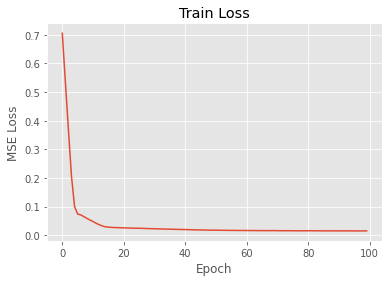

In [30]:
# Epoch 300 Loss is 0.0021550819316568473
fig, ax = plt.subplots()
plt.plot(all_epochs_loss)

ax.set_title('Train Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
plt.show()

In [12]:
def test_TST(model, X):
    model.eval()
    torch.cuda.empty_cache()
    S = X.shape[1] # Sequence Length
    src_mask = model.generate_square_subsequent_mask(S)
    predicted = model(X.permute(1,0,2),None,None).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[-1,:,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print(predicted.shape)
    print('TST: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps
forecasted_TST = test_TST(TST_model, X=X_test).cpu().detach().numpy()

torch.Size([40, 81, 2])
TST: Test MSE Loss:  0.04429840296506882


In [13]:
X_train[-1].shape

torch.Size([40, 2])

In [14]:
def forecast_TST(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(1) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,],None,None).to(device) # [S,B,E] 
        one_new_timestep=predicted[-1,:,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),0)  # add the forecasted timestep
        
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_TST = forecast_TST(TST_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size ).cpu().detach().numpy()

Test MSE Loss:  tensor(0.0485, device='cuda:0', grad_fn=<MseLossBackward>)


In [15]:
print("We used {} Parameters for the transformer model".format(count_parameters(TST_model)))

We used 398978 Parameters for the transformer model


In [16]:
forecasted_inverse_TST = scaler.inverse_transform(forecasted_TST)

In [17]:
print('R2 Score for Cases',r2_score(daily_to_cumulative(y_test_inverse[:,0]),daily_to_cumulative(forecasted_inverse_TST[:,0])))
print('MAPE Score for Cases',mean_absolute_percentage_error(y_test_inverse[:,0],forecasted_inverse_TST[:,0]))

print('R2 Score for Deaths',r2_score(daily_to_cumulative(y_test_inverse[:,1]),daily_to_cumulative(forecasted_inverse_TST[:,1])))
print('MAPE Score for Deaths',mean_absolute_percentage_error(y_test_inverse[:,1],forecasted_inverse_TST[:,1]))

R2 Score for Cases 0.7602066562119147
MAPE Score for Cases 0.26403564
R2 Score for Deaths 0.9157185586463809
MAPE Score for Deaths 0.48442286


# LSTM Model

In [18]:
LSTM_model = COVID_LSTM(n_hidden=128,n_features=2).to(device)
criterion=torch.nn.MSELoss()
optimizer = optim.Adam(LSTM_model.parameters(), lr=0.0001)
all_epochs_loss = LSTM_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(LSTM_model.state_dict(), 'Weights/model_LSTM_{}'.format(state))
# LSTM_model.load_state_dict(torch.load('Weights/model_LSTM_{}'.format(state)))

Epoch 1 Loss is 0.6398954808712005
Epoch 2 Loss is 0.5875165462493896
Epoch 3 Loss is 0.5273387581110001
Epoch 4 Loss is 0.4453007221221924
Epoch 5 Loss is 0.3116879418492317
Epoch 6 Loss is 0.13641984686255454
Epoch 7 Loss is 0.10538025721907615
Epoch 8 Loss is 0.09234609715640545
Epoch 9 Loss is 0.08373610600829125
Epoch 10 Loss is 0.07681798115372658
Epoch 11 Loss is 0.06993371061980724
Epoch 12 Loss is 0.06209472920745611
Epoch 13 Loss is 0.053528519533574584
Epoch 14 Loss is 0.0460389245301485
Epoch 15 Loss is 0.039557619392871855
Epoch 16 Loss is 0.03529538325965405
Epoch 17 Loss is 0.03239365741610527
Epoch 18 Loss is 0.030859661102294923
Epoch 19 Loss is 0.029991936311125754
Epoch 20 Loss is 0.02933134501799941
Epoch 21 Loss is 0.02898209262639284
Epoch 22 Loss is 0.028380428440868855
Epoch 23 Loss is 0.02829422652721405
Epoch 24 Loss is 0.027936491556465624
Epoch 25 Loss is 0.028196121752262115
Epoch 26 Loss is 0.02711544819176197
Epoch 27 Loss is 0.026777418050915002
Epoch 28

In [19]:
def test_LSTM(model, X):
    model.eval()
    torch.cuda.empty_cache()
    predicted = model(X).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[:,-1,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print('LSTM: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps

forecasted_LSTM = test_LSTM(LSTM_model, X=X_test).cpu().detach().numpy()

LSTM: Test MSE Loss:  0.06745884567499161


In [20]:
X_test.shape

torch.Size([81, 40, 2])

In [21]:
def forecast_LSTM(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(0) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,]).to(device) # [B,S,E] 
        
        one_new_timestep=predicted[:,-1,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),1)  # add the forecasted timestep
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_LSTM = forecast_LSTM(LSTM_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size ).cpu().detach().numpy()

Test MSE Loss:  tensor(0.0769, device='cuda:0', grad_fn=<MseLossBackward>)


In [22]:
forecasted_inverse_LSTM = scaler.inverse_transform(forecasted_LSTM)

In [23]:
print('R2 Score for Cases',r2_score(daily_to_cumulative(y_test_inverse[:,0]),daily_to_cumulative(forecasted_inverse_LSTM[:,0])))
print('MAPE Score for Cases',mean_absolute_percentage_error(y_test_inverse[:,0],forecasted_inverse_LSTM[:,0]))

print('R2 Score for Deaths',r2_score(daily_to_cumulative(y_test_inverse[:,1]),daily_to_cumulative(forecasted_inverse_LSTM[:,1])))
print('MAPE Score for Deaths',mean_absolute_percentage_error(y_test_inverse[:,1],forecasted_inverse_LSTM[:,1]))

R2 Score for Cases 0.25010980753686085
MAPE Score for Cases 0.33157974
R2 Score for Deaths 0.020129610531306907
MAPE Score for Deaths 0.53098536


# GRU Model

In [24]:
GRU_model = COVID_GRU(n_hidden=128,n_features=2).to(device)
criterion=torch.nn.MSELoss()
optimizer = optim.Adam(GRU_model.parameters(), lr=0.0001)
all_epochs_loss = GRU_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(GRU_model.state_dict(), 'Weights/model_GRU_{}'.format(state))
# GRU_model.load_state_dict(torch.load('Weights/model_GRU_{}'.format(state)))

Epoch 1 Loss is 0.7054332613945007
Epoch 2 Loss is 0.535452064871788
Epoch 3 Loss is 0.3675701320171356
Epoch 4 Loss is 0.20483387559652327
Epoch 5 Loss is 0.0996417123824358
Epoch 6 Loss is 0.07440746910870075
Epoch 7 Loss is 0.0711254358291626
Epoch 8 Loss is 0.06522209011018276
Epoch 9 Loss is 0.05890081562101841
Epoch 10 Loss is 0.053315451741218566
Epoch 11 Loss is 0.047986901551485064
Epoch 12 Loss is 0.04193001911044121
Epoch 13 Loss is 0.03696957118809223
Epoch 14 Loss is 0.03275739271193743
Epoch 15 Loss is 0.029545402713119985
Epoch 16 Loss is 0.028402087837457658
Epoch 17 Loss is 0.027474679239094257
Epoch 18 Loss is 0.026980315800756216
Epoch 19 Loss is 0.02664909968152642
Epoch 20 Loss is 0.02628172691911459
Epoch 21 Loss is 0.025857945438474417
Epoch 22 Loss is 0.025540721230208875
Epoch 23 Loss is 0.025187208224087952
Epoch 24 Loss is 0.024900423269718884
Epoch 25 Loss is 0.024607082456350328
Epoch 26 Loss is 0.024330518767237665
Epoch 27 Loss is 0.024209225829690696
Epo

In [25]:
def test_GRU(model, X):
    model.eval()
    torch.cuda.empty_cache()
    predicted = model(X).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[:,-1,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print('GRU: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps

forecasted_GRU = test_GRU(GRU_model, X=X_test).cpu().detach().numpy()

GRU: Test MSE Loss:  0.06015042960643768


In [26]:
X_test.shape

torch.Size([81, 40, 2])

In [27]:
def forecast_GRU(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(0) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,]).to(device) # [B,S,E] 
        
        one_new_timestep=predicted[:,-1,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),1)  # add the forecasted timestep
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_GRU = forecast_GRU(GRU_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size ).cpu().detach().numpy()

Test MSE Loss:  tensor(0.0812, device='cuda:0', grad_fn=<MseLossBackward>)


In [28]:
forecasted_inverse_GRU = scaler.inverse_transform(forecasted_GRU)

In [29]:
print('R2 Score for Cases',r2_score(daily_to_cumulative(y_test_inverse[:,0]),daily_to_cumulative(forecasted_inverse_GRU[:,0])))
print('MAPE Score for Cases',mean_absolute_percentage_error(y_test_inverse[:,0],forecasted_inverse_GRU[:,0]))

print('R2 Score for Deaths',r2_score(daily_to_cumulative(y_test_inverse[:,1]),daily_to_cumulative(forecasted_inverse_GRU[:,1])))
print('MAPE Score for Deaths',mean_absolute_percentage_error(y_test_inverse[:,1],forecasted_inverse_GRU[:,1]))

R2 Score for Cases -0.038416435499453616
MAPE Score for Cases 0.32918215
R2 Score for Deaths 0.3427895572697406
MAPE Score for Deaths 0.4865717


# Plots

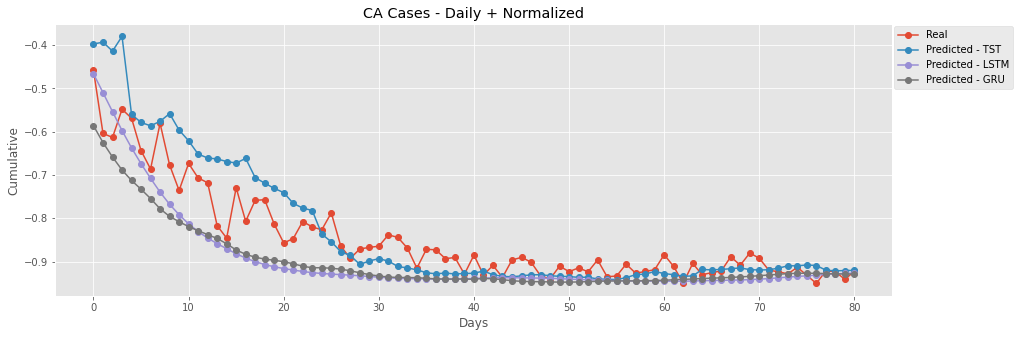

In [33]:
fig, ax = plt.subplots()
# ax.set_ylim([0.0,1.1])

plt.plot(y_test[:,0].cpu().detach().numpy(),label='Real',marker='o')
plt.plot(forecasted_TST[:,0],label='Predicted - TST',marker='o')
plt.plot(forecasted_LSTM[:,0],label='Predicted - LSTM',marker='o')
plt.plot(forecasted_GRU[:,0],label='Predicted - GRU',marker='o')

# plt.plot(forecasted_once_TST[:,0].cpu().detach().numpy(),label='Forecast Function - TST',marker='o')
fig.set_size_inches(15, 5)
ax.set_title('{} Cases - Daily + Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()

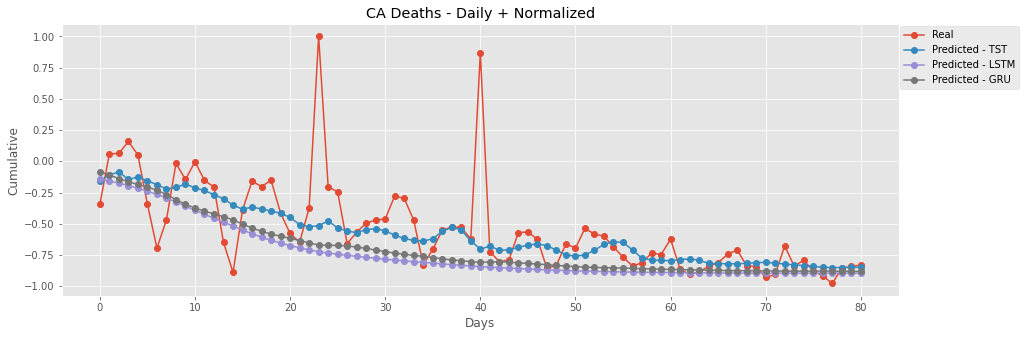

In [34]:
fig, ax = plt.subplots()
# ax.set_ylim([0.0,1.1])

plt.plot(y_test[:,1].cpu().detach().numpy(),label='Real',marker='o')
plt.plot(forecasted_TST[:,1],label='Predicted - TST',marker='o')
plt.plot(forecasted_LSTM[:,1],label='Predicted - LSTM',marker='o')
plt.plot(forecasted_GRU[:,1],label='Predicted - GRU',marker='o')

# plt.plot(forecasted_once_TST[:,1].cpu().detach().numpy(),label='Forecast Function - TST',marker='o')

fig.set_size_inches(15, 5)
ax.set_title('{} Deaths - Daily + Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()

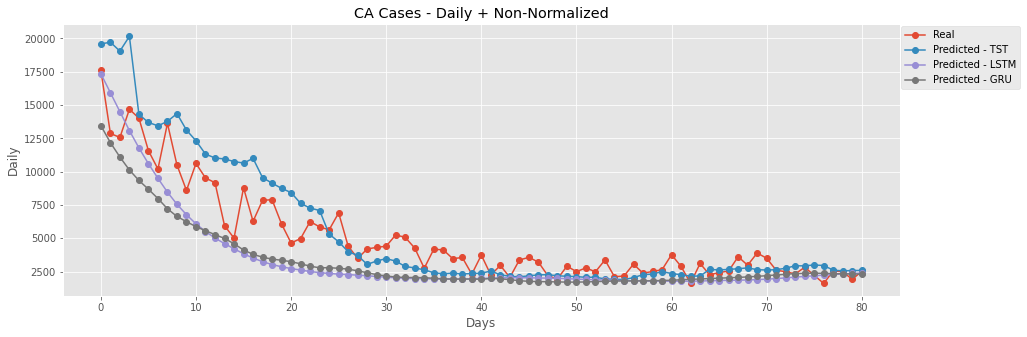

In [35]:
fig, ax = plt.subplots()

plt.plot(y_test_inverse[:,0],label='Real',marker='o')
plt.plot(forecasted_inverse_TST[:,0],label='Predicted - TST',marker='o')
plt.plot(forecasted_inverse_LSTM[:,0],label='Predicted - LSTM',marker='o')
plt.plot(forecasted_inverse_GRU[:,0],label='Predicted - GRU',marker='o')

fig.set_size_inches(15, 5)
ax.set_title('{} Cases - Daily + Non-Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Daily')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()

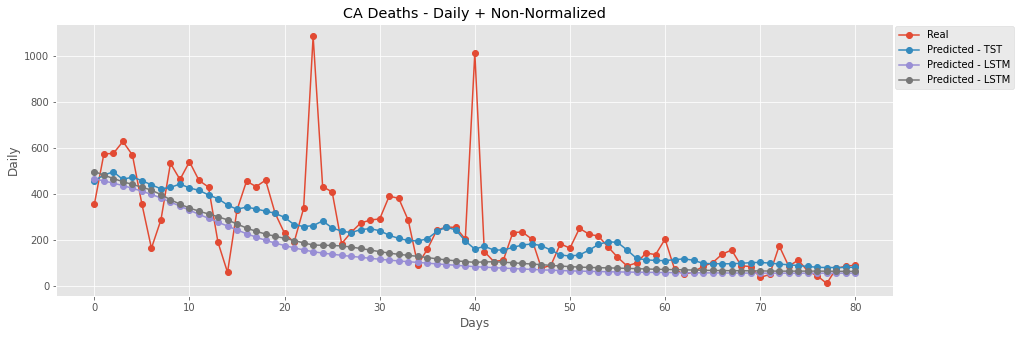

In [36]:
fig, ax = plt.subplots()

plt.plot(y_test_inverse[:,1],label='Real',marker='o')
plt.plot(forecasted_inverse_TST[:,1],label='Predicted - TST',marker='o')
plt.plot(forecasted_inverse_LSTM[:,1],label='Predicted - LSTM',marker='o')
plt.plot(forecasted_inverse_GRU[:,1],label='Predicted - LSTM',marker='o')

fig.set_size_inches(15, 5)
ax.set_title('{} Deaths - Daily + Non-Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Daily')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()